In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/food41

!unzip food41.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tac

In [3]:
# Globals
IMG_SIZE = (224,224) # Resolução da imagem
batch_size = 32

In [4]:
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

In [5]:
image_dir = Path('/content/images')

In [6]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(500, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [7]:
os.path.split(filepaths[0])

('/content/images/poutine', '1197602.jpg')

In [8]:
image_df['Label'].value_counts()

caprese_salad           500
beet_salad              500
onion_rings             500
cup_cakes               500
sushi                   500
                       ... 
steak                   500
grilled_salmon          500
bread_pudding           500
breakfast_burrito       500
pulled_pork_sandwich    500
Name: Label, Length: 101, dtype: int64

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

In [10]:
# Pré-processando a imagem de entrada usando o Effectivenet
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [11]:
train_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 30300 validated image filenames belonging to 101 classes.
Found 7575 validated image filenames belonging to 101 classes.
Found 12625 validated image filenames belonging to 101 classes.


# **Modelagem**

In [12]:
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [13]:
model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.applications.EfficientNetB0(
            input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False,
            drop_connect_rate=0.5
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(400, activation='sigmoid'),
        tf.keras.layers.Dense(101, activation='softmax') 
])


16719872/16705208 [==============================] - 0s 0us/step


In [14]:
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint

model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = 'categorical_crossentropy', 
    metrics=['accuracy']
) 

history = model.fit(
    train_data, 
    validation_data=val_data,
    epochs= 10,
    callbacks=[EarlyStopping(monitor = 'val_loss',patience = 5,verbose = 1,restore_best_weights = True), 
               CSVLogger('model5a.log'), 
               ReduceLROnPlateau(monitor = 'val_loss',patience = 1,verbose = 1), 
               ModelCheckpoint('model5a.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)]
)

Epoch 1/10
947/947 [==============================] - ETA: 0s - loss: 2.5121 - accuracy: 0.3871
Epoch 1: val_loss improved from inf to 1.85568, saving model to model5a.01-1.86.hdf5
947/947 [==============================] - 386s 373ms/step - loss: 2.5121 - accuracy: 0.3871 - val_loss: 1.8557 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 2/10
947/947 [==============================] - ETA: 0s - loss: 1.6281 - accuracy: 0.5746
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_loss did not improve from 1.85568
947/947 [==============================] - 339s 358ms/step - loss: 1.6281 - accuracy: 0.5746 - val_loss: 2.0940 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 3/10
947/947 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.7131
Epoch 3: val_loss improved from 1.85568 to 1.27388, saving model to model5a.03-1.27.hdf5
947/947 [==============================] - 339s 358ms/step - loss: 1.0844 - accuracy: 0.7131 - val_loss: 1.2739 - val

In [15]:
# Como o modelo se comporta nos dados de teste
results = model.evaluate(test_data, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 73.08%


In [ ]:
# Traçando a Matriz de Confusão e o Relatório de Classificação para ver como o modelo se comporta 
predictions = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(test_data.labels, predictions)
clr = classification_report(test_data.labels, predictions, target_names=test_data.class_indices, zero_division=0)

In [37]:
with open("random.csv", "w") as fp:
    fp.write(clr)

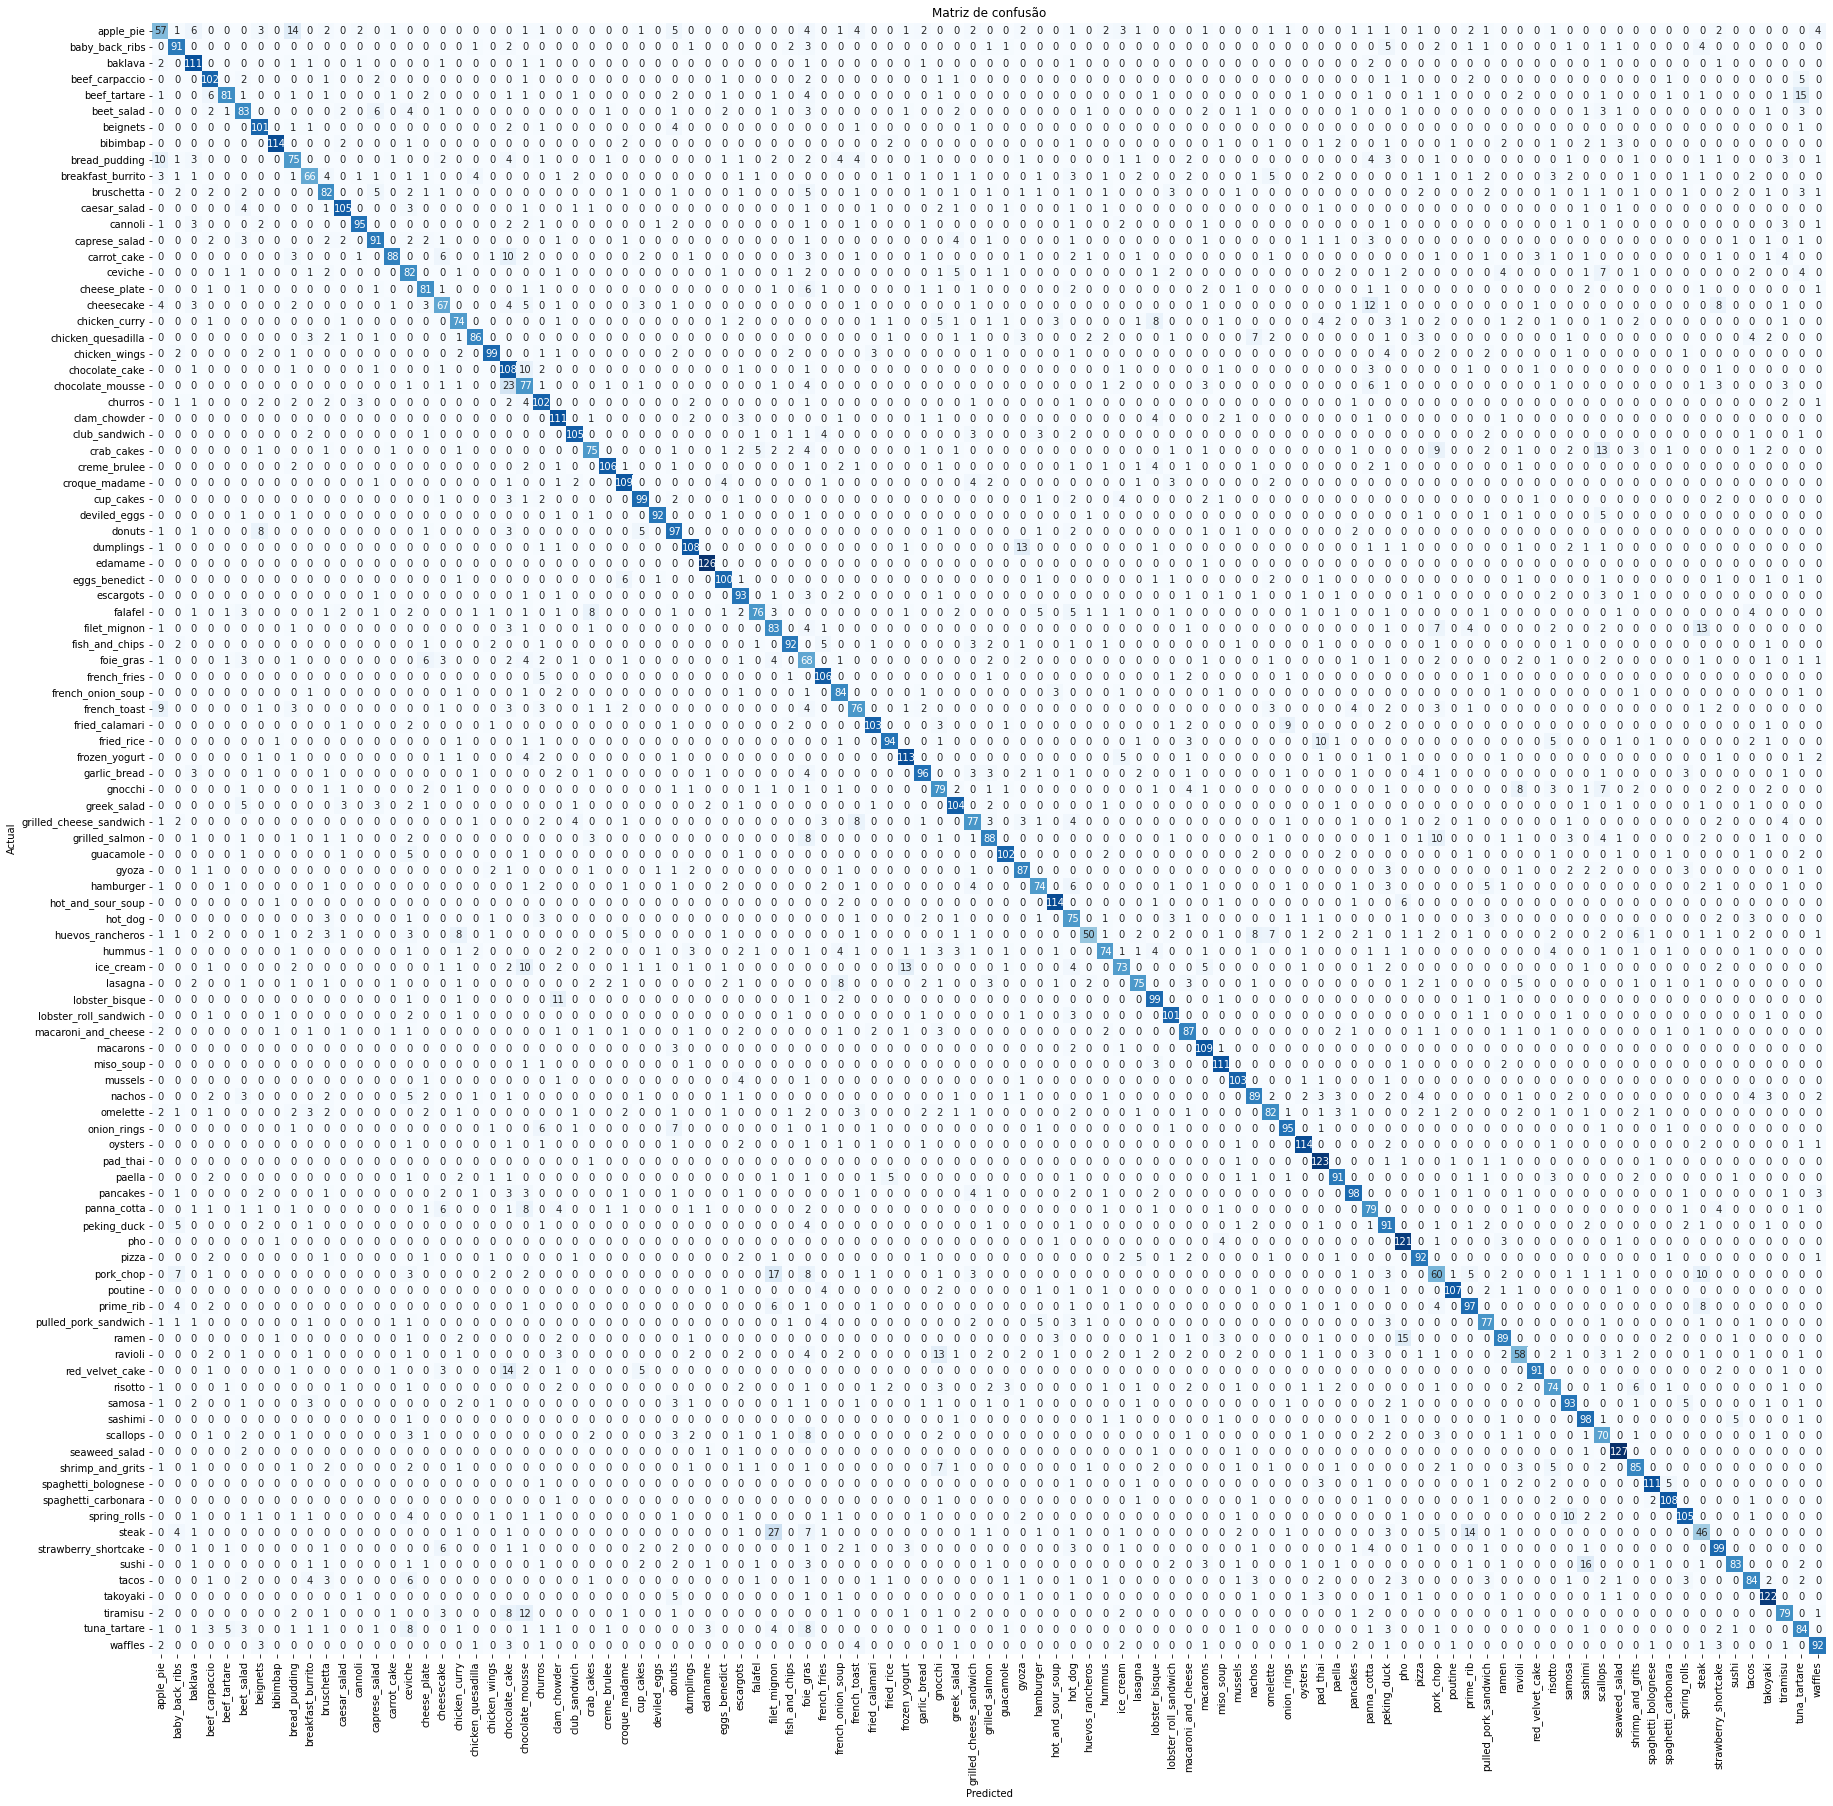

In [17]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_data.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_data.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de confusão")
plt.show()

In [ ]:
# Traçando os resultados
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Treinamento e validação accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Treinamento e validação loss')

plt.legend()
plt.show()

In [30]:
# Relatório de classificação
print("                       Relatório de classificação:\n----------------------\n", clr)

                       Relatório de classificação:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.53      0.43      0.47       134
         baby_back_ribs       0.72      0.77      0.74       118
                baklava       0.75      0.88      0.81       126
         beef_carpaccio       0.73      0.83      0.78       123
           beef_tartare       0.87      0.61      0.72       132
             beet_salad       0.64      0.66      0.65       126
               beignets       0.77      0.89      0.83       113
               bibimbap       0.94      0.83      0.88       138
          bread_pudding       0.59      0.56      0.57       134
      breakfast_burrito       0.70      0.53      0.60       125
             bruschetta       0.65      0.62      0.63       133
           caesar_salad       0.84      0.83      0.83       127
                cannoli       0.91      0.77      0.84       123
          capr

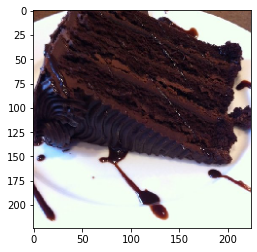

In [20]:
# Modelos de teste em imagens únicas (IMP)
from tensorflow.keras.preprocessing import image
img_path = Path('/content/images/chocolate_cake/1001084.jpg')
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_batch)

In [21]:
Categories = sorted(os.listdir('/content/images'))
Categories

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [22]:
# Prediciting
Categories[np.argmax(model.predict([img_preprocessed]))]

'chocolate_cake'

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmplfwowdau/assets


In [ ]:
import os

_, _, files = next(os.walk("/content/images/apple_pie"))
file_count = len(files)

In [25]:
file_count

1000

1000